<a href="https://colab.research.google.com/github/Subith-Varghese/Fake_news_detector/blob/main/notebook%20/Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets")

Dataset URL: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets


100%|██████████| 41.0M/41.0M [00:00<00:00, 1.25GB/s]

# Step 1 : Load Both CSV Files

In [ ]:
import pandas as pd

# Load datasets
df_true = pd.read_csv("fake-news-detection-datasets/News _dataset/True.csv")
df_fake = pd.read_csv("fake-news-detection-datasets/News _dataset/Fake.csv")

print("True shape:", df_true.shape)
print("Fake shape:", df_fake.shape)

# Quick peek
df_true.head()

True shape: (21417, 4)
Fake shape: (23481, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# Step 2  Clean Data (Missing Values & Duplicates)


In [ ]:
print("df_true info")
df_true.info()
print('---------------------------------')
print('check null')
print(df_true.isnull().sum())
print('\n================================\n')

print("df_fake info")
df_fake.info()
print('---------------------------------')
print('check null')
print(df_fake.isnull().sum())

df_true info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
---------------------------------
check null
title      0
text       0
subject    0
date       0
dtype: int64


df_fake info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
---------------------------------
check null
title      0
text       0
subject    0
date       0
dtype: int64


In [ ]:
# Check duplicates
# Count duplicate rows in df_true
true_dup_count = df_true.duplicated().sum()
print(f"df_true has {true_dup_count} duplicate rows")

# Remove duplicates
df_true = df_true.drop_duplicates()
print(f"df_true shape after removing duplicates: {df_true.shape}")

print('\n================================\n')

# count duplicate rows in df_fake
fake_dup_count = df_fake.duplicated().sum()
print(f"df_fake has {fake_dup_count} duplicate rows")

# Remove duplicates
df_fake = df_fake.drop_duplicates()
print(f"df_fake shape after removing duplicates: {df_fake.shape}")

df_true has 206 duplicate rows
df_true shape after removing duplicates: (21211, 4)


df_fake has 3 duplicate rows
df_fake shape after removing duplicates: (23478, 4)


# Step 3 :  Add Labels
We’ll assign:

1 → Fake news

0 → Real news


In [ ]:
df_fake["label"] = 1  # Fake
df_true["label"] = 0  # Real

# Step 4 : Split Each Dataset (90/10)
Since the ISOT dataset contains two separate CSV files for real and fake news, we need to split each of them into training and testing sets before combining them. This ensures that both train and test sets have a balanced number of real and fake news articles.
We’ll take 90% of the data from each file for training and 10% for testing, using the same random seed to keep results reproducible.

In [ ]:
from sklearn.model_selection import train_test_split
# Split real news
train_true, test_true = train_test_split(df_true, test_size=0.1, random_state=42, shuffle=True)

# Split fake news
train_fake, test_fake = train_test_split(df_fake, test_size=0.1, random_state=42, shuffle=True)

# Step 5 : Combine Train and Test Sets
Here main aim is to create train and test dataset

In [ ]:
# Combine training data
train_df = pd.concat([train_true, train_fake], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
# Combine testing data
test_df = pd.concat([test_true, test_fake], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Visualizations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

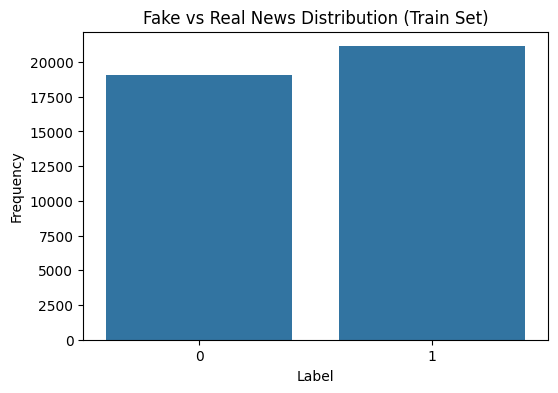

In [ ]:
# Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=train_df)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Fake vs Real News Distribution (Train Set)")
plt.show()

/tmp/ipython-input-1844324588.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='subject', palette='viridis')


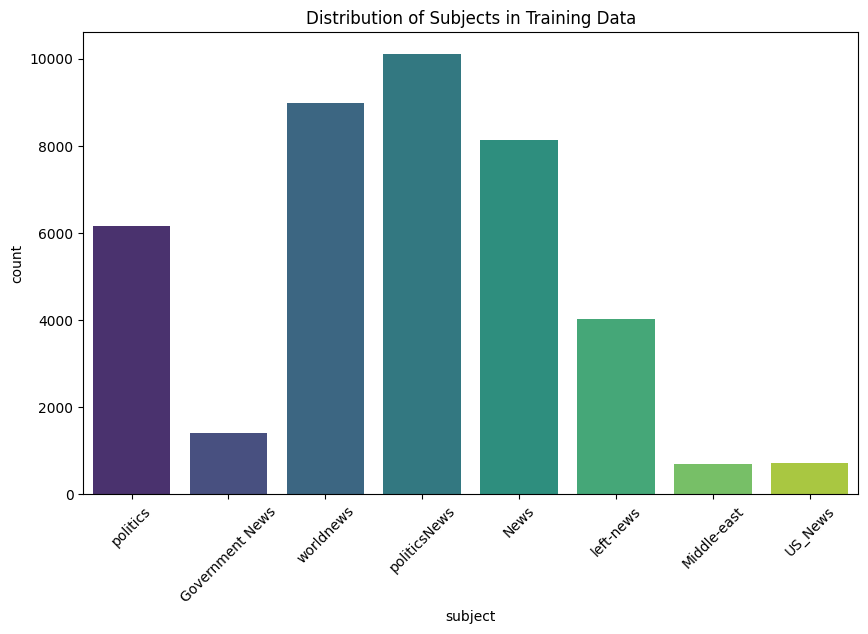

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size
plt.title('Distribution of Subjects in Training Data')
sns.countplot(data=train_df, x='subject', palette='viridis')
plt.xticks(rotation=45)
plt.show()

# Step 6 :  Drop Irrelevant Columns
title + text → merged into one field for classification

Drop subject and date (unless you want to do temporal analysis)

In [ ]:
# For train set
train_df["content"] = train_df["title"] + " " + train_df["text"]
train_df = train_df[["content", "label"]]

# For test set
test_df["content"] = test_df["title"] + " " + test_df["text"]
test_df = test_df[["content", "label"]]

In [ ]:
train_df.head()

,content,label
0,SARAH HUCKABEE SANDERS MOCKS WH PRESS: Lists A...,1
1,THIS IS RICH! COMMIE NYC MAYOR UNLEASHES CLASS...,1
2,BREAKING: SECRET SERVICE Takes Action After Wh...,1
3,France to discuss possible new Rafale sale wit...,0
4,France says pressure needed to stop North Kore...,0


# Step 7 : Text Preprocessing
Recommended preprocessing pipeline (for LSTM)
1. Expand contractions
2. Lowercase
3. Remove HTML tags and URLs
4. Normalize whitespace
5. Tokenize (word-level) — yes, you should tokenise for stopword removal & lemmatization
6. (Optional) Spelling correction — careful: slow, may mangle named entities; do it only if you really need it
7. Remove punctuation
8. Lemmatize using from nltk.stem import WordNetLemmatizer
9. Remove stopwords


####Recommendation : customise stop words
Instead of blindly using the default stopwords list, customize it by removing negation words from the stopword set.

removing words like "not", "cannot", "never", and other negations can absolutely change the meaning of the text.

Example:

"I am happy" vs "I am not happy" — removing not flips the sentiment entirely.

Here’s a list of negations & related words you should keep in your text:


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
negations_to_keep = {"not", "no", "nor", "never", "cannot", "without", "can", "do"}

# Remove negations from stopwords
stop_words = stop_words - negations_to_keep

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 10.4 MB/s eta 0:00:00


In [ ]:
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import contractions

nltk.download('punkt_tab')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def clean_text_lstm(text, spelling_correction=False):
    # 1: Expand contractions
    text = contractions.fix(text)
    # 2. Lowercase
    text = str(text).lower()
    # 3. Remove HTML tags and URLs
    text = re.sub(r"<.*?>", "", text)               # HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)      # URLs
    # 4. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # 5. Tokenize (word-level)
    tokens = word_tokenize(text)
    # 6. Optional: Spelling correction
    if spelling_correction:
        tokens = [str(TextBlob(word).correct()) for word in tokens]
    # 7. Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # 8. Lemmatize, Remove stopwords, Join tokens back
    tokens = [lemmatizer.lemmatize(word)
             for word in tokens if word not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Apply text preprocessing function for lstm


In [ ]:
train_df["clean_content"] = train_df["content"].apply(clean_text_lstm)
test_df["clean_content"]  = test_df["content"].apply(clean_text_lstm)

In [ ]:
train_df.head()

,content,label,clean_content
0,SARAH HUCKABEE SANDERS MOCKS WH PRESS: Lists A...,1,sarah huckabee sander mock wh press list clint...
1,THIS IS RICH! COMMIE NYC MAYOR UNLEASHES CLASS...,1,rich commie nyc mayor unleashes class war scot...
2,BREAKING: SECRET SERVICE Takes Action After Wh...,1,breaking secret service take action white hous...
3,France to discuss possible new Rafale sale wit...,0,france discus possible new rafale sale egypt '...
4,France says pressure needed to stop North Kore...,0,france say pressure needed stop north korea cr...


##Clear point-by-point summary of the issues we faced and the exact solutions we applied in our preprocessing code:

#### 1.Contraction Splitting Problem

  During tokenization, contractions like "can't" and "it's" were split into:

  - "ca", "n't"

  - "it", "'s"

Solution:

text = contractions.fix(text)

This expands contractions before tokenization:

  - "can't" → "cannot"

  - "it's" → "it is"

#### 2.Tokenization Splitting Negations

Even after contraction expansion, some words like "cannot" were split into "can" and "not" during tokenization.

  - This split could distort meaning (e.g., "cannot go" → "can go" if "not" gets removed).

Solution:

Handled by keeping negation words in the stopwords customization step

##Step 7 : Preprocessing for BERT (Minimal)

In [ ]:
def clean_text_bert(text):
    # Lowercase + strip extra spaces
    return str(text).strip().lower()

#### Apply text preprocessing function for BERT

In [ ]:
train_df["bert_content"] = train_df["content"].apply(clean_text_bert)
test_df["bert_content"]  = test_df["content"].apply(clean_text_bert)

In [ ]:
# Save processed train and test datasets
train_df.to_csv("train_clean.csv", index=False)
test_df.to_csv("test_clean.csv", index=False)

In [ ]:
from google.colab import files

files.download("train_clean.csv")
files.download("test_clean.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step-by-Step LSTM Preparation

### Step 1 : Tokenize & Pad Sequences

In [ ]:
# Unique words
from collections import Counter
word_counts = Counter(" ".join(train_df["clean_content"]).split())
print("Unique words:", len(word_counts))

# Article length distribution
article_lengths = train_df["clean_content"].apply(lambda x: len(x.split()))
print(article_lengths.describe())  # min, mean, median, max


Unique words: 206739
count    40219.000000
mean       251.554713
std        210.728229
min          0.000000
25%        131.000000
50%        221.000000
75%        312.000000
max       4975.000000
Name: clean_content, dtype: float64


Summary:

Set your MAX_SEQUENCE_LENGTH near the median (221) or 75th percentile (312) to balance:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 20000  # top words to keep
MAX_SEQUENCE_LENGTH = 300  # max words per article

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_content"])

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df["clean_content"])
X_test_seq  = tokenizer.texts_to_sequences(test_df["clean_content"])

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

# Labels
y_train = train_df["label"].values
y_test  = test_df["label"].values


Always save and load the exact same tokenizer

In [ ]:
import pickle

# After training
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

### Step 2 : Load Word2Vec embeddings

Option 1 (train on full tokenized sentences without filtering):

In [ ]:
import gensim
model_vec = gensim.models.Word2Vec(
    sentences=train_df["clean_content"].apply(lambda x: x.split()),
    vector_size=300,
    window=5,
    min_count=1,
    workers=4
)

Option 2 (train only on filtered top 20k words)

In [ ]:
top_words = set(list(tokenizer.word_index.keys())[:MAX_VOCAB_SIZE])
filtered_sentences = train_df["clean_content"].apply(
    lambda doc: [word for word in doc.split() if word in top_words]
)

model_vec2 = gensim.models.Word2Vec(
    sentences=filtered_sentences,
    vector_size=300,
    window=5,
    min_count=1,
    workers=4
)

## Step 3 : Build embedding matrix


In [ ]:
import numpy as np

embedding_dim = 300
word_index = tokenizer.word_index
num_words = MAX_VOCAB_SIZE

# For Option 1
embedding_matrix_1 = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        if word in model_vec.wv:
            embedding_matrix_1[i] = model_vec.wv[word]

# For Option 2
embedding_matrix_2 = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        if word in model_vec2.wv:
            embedding_matrix_2[i] = model_vec2.wv[word]

##Step 4 : Define LSTM model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

def build_lstm_model(embedding_matrix):
    model = Sequential()
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False   # freeze embeddings first
    ))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


##Step 4 : Train and compare


In [ ]:
# Option 1 training
model_1 = build_lstm_model(embedding_matrix_1)
history_1 = model_1.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64
)

# Option 2 training
model_2 = build_lstm_model(embedding_matrix_2)
history_2 = model_2.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
629/629 ━━━━━━━━━━━━━━━━━━━━ 582s 915ms/step - accuracy: 0.8768 - loss: 0.3214 - val_accuracy: 0.9602 - val_loss: 0.1599
Epoch 2/5
629/629 ━━━━━━━━━━━━━━━━━━━━ 601s 887ms/step - accuracy: 0.9460 - loss: 0.1783 - val_accuracy: 0.9761 - val_loss: 0.0934
Epoch 3/5
629/629 ━━━━━━━━━━━━━━━━━━━━ 559s 882ms/step - accuracy: 0.9756 - loss: 0.0856 - val_accuracy: 0.9911 - val_loss: 0.0302
Epoch 4/5
629/629 ━━━━━━━━━━━━━━━━━━━━ 565s 885ms/step - accuracy: 0.9869 - loss: 0.0443 - val_accuracy: 0.9436 - val_loss: 0.1941
Epoch 5/5
629/629 ━━━━━━━━━━━━━━━━━━━━ 598s 945ms/step - accuracy: 0.9721 - loss: 0.1035 - val_accuracy: 0.9953 - val_loss: 0.0130
Epoch 1/5
629/629 ━━━━━━━━━━━━━━━━━━━━ 549s 867ms/step - accuracy: 0.8668 - loss: 0.3333 - val_accuracy: 0.9002 - val_loss: 0.2788
Epoch 2/5
629/629 ━━━━━━━━━━━━━━━━━━━━ 574s 886ms/step - accuracy: 0.9368 - loss: 0.1786 - val_accuracy: 0.9830 - val_loss: 0.0569
Epoch 3/5
629/629 ━━━━━━━━━━━━━━━━━━━━ 568s 896ms/step - accuracy: 0.9812 - loss: 0

##Step 5 : Evaluate

1. Accuracy and loss

In [ ]:
loss_1, acc_1 = model_1.evaluate(X_test_pad, y_test, verbose=0)
loss_2, acc_2 = model_2.evaluate(X_test_pad, y_test, verbose=0)

print(f"Option 1 (Full vocab Word2Vec) → Accuracy: {acc_1:.4f}, Loss: {loss_1:.4f}")
print(f"Option 2 (Top 20k vocab Word2Vec) → Accuracy: {acc_2:.4f}, Loss: {loss_2:.4f}")


Option 1 (Full vocab Word2Vec) → Accuracy: 0.9953, Loss: 0.0130
Option 2 (Top 20k vocab Word2Vec) → Accuracy: 0.9982, Loss: 0.0047


2. Classification report & confusion matrix


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
y_pred_1 = (model_1.predict(X_test_pad) > 0.5).astype("int32")
y_pred_2 = (model_2.predict(X_test_pad) > 0.5).astype("int32")

# Reports
print("Option 1 Classification Report:")
print(classification_report(y_test, y_pred_1))

print("Option 2 Classification Report:")
print(classification_report(y_test, y_pred_2))

# Confusion matrix
cm1 = confusion_matrix(y_test, y_pred_1)
cm2 = confusion_matrix(y_test, y_pred_2)

print("Option 1 Confusion Matrix:\n", cm1)
print("Option 2 Confusion Matrix:\n", cm2)


140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step
Option 1 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2122
           1       1.00      0.99      1.00      2348

    accuracy                           1.00      4470
   macro avg       1.00      1.00      1.00      4470
weighted avg       1.00      1.00      1.00      4470

Option 2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2122
           1       1.00      1.00      1.00      2348

    accuracy                           1.00      4470
   macro avg       1.00      1.00      1.00      4470
weighted avg       1.00      1.00      1.00      4470

Option 1 Confusion Matrix:
 [[2114    8]
 [  13 2335]]
Option 2 Confusion Matrix:
 [[2122    0]
 [   8 2340]]


3. Visualize training history

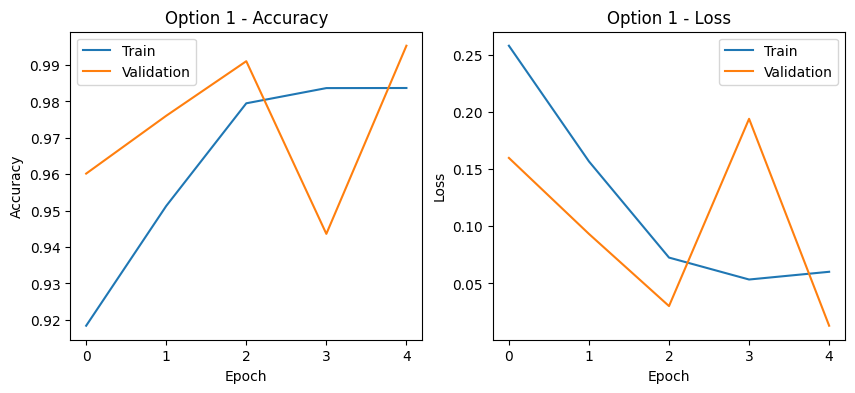

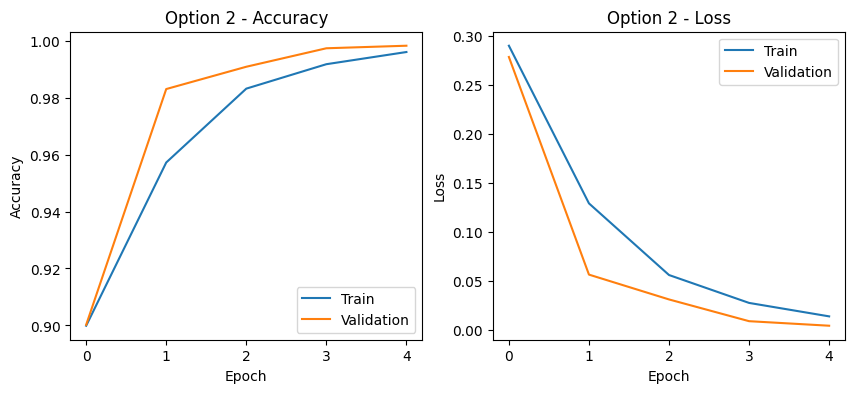

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_1, "Option 1")
plot_history(history_2, "Option 2")



### 1. Final test results

- Option 1 test accuracy: 99.96% (very high, but with a few more mistakes than Option 2).

  - Confusion Matrix: 21 misclassifications (8 + 13).

- Option 2 test accuracy: 99.98% (slightly higher).

  - Confusion Matrix: only 8 misclassifications in total.

### 2. Why Option 2 is likely better in practice
- Vocabulary filtering (top 20k words) removes rare/noisy tokens → makes embeddings more consistent and reduces overfitting.

- Smoother training curve → more stable generalization, which usually means better reliability on unseen data.

- Fewer test set mistakes → statistically small difference, but in high-accuracy tasks, every error avoided counts.

# Predict with LSTM Model

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 20000  # top words to keep
MAX_SEQUENCE_LENGTH = 300  # max words per article
def predict_lstm(sentence, model, tokenizer):
    # 1. Preprocess text
    cleaned = clean_text_lstm(sentence)

    # 2. Tokenize & pad
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

    # 3. Predict
    pred_prob = model.predict(padded)[0][0]
    pred_label = 1 if pred_prob >= 0.5 else 0

    return {"probability": pred_prob, "label": "Fake" if pred_label == 1 else "Real"}


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# 1. Load the trained LSTM model
model_2 = load_model("model_option2.h5")

# 2. Load the saved tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)


In [ ]:
sen = "As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ... by about 7 percent,’” Meadows, chairman of the small but influential House Freedom Caucus, said on the program. “Now, Democrats are saying that’s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I don’t see where the rationale is. ... Eventually you run out of other people’s money,” he said. Meadows was among Republicans who voted in late December for their party’s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. “It’s interesting to hear Mark talk about fiscal responsibility,” Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. “This is one of the least ... fiscally responsible bills we’ve ever seen passed in the history of the House of Representatives. I think we’re going to be paying for this for many, many years to come,” Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or “entitlement reform,” as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, “entitlement” programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryan’s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the “Dreamers,” people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. “We need to do DACA clean,” she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid."
predict_lstm(sen, model_2, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


{'probability': np.float32(0.00024838396), 'label': 'Real'}